In [1]:
import datetime as dt
from tracker.tracker import get_owned
from optimizer.ingestion import get_data
from optimizer.optimization import plot_results

In [2]:
assets = get_owned()
# assets = ['BTC-USD', 'ETH-USD', 'ADA-USD', 'SOL1-USD']

# assets = ['CEVA', 'GOOGL', 'TSLA', 'ZOM']

end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=90)

# start_date = dt.date(2021, 1, 1)
# end_date = dt.date(2021, 1, 23)

mean_returns, cov_matrix, delta_days = get_data(assets, start_date, end_date, log=False)


[*********************100%***********************]  26 of 26 completed


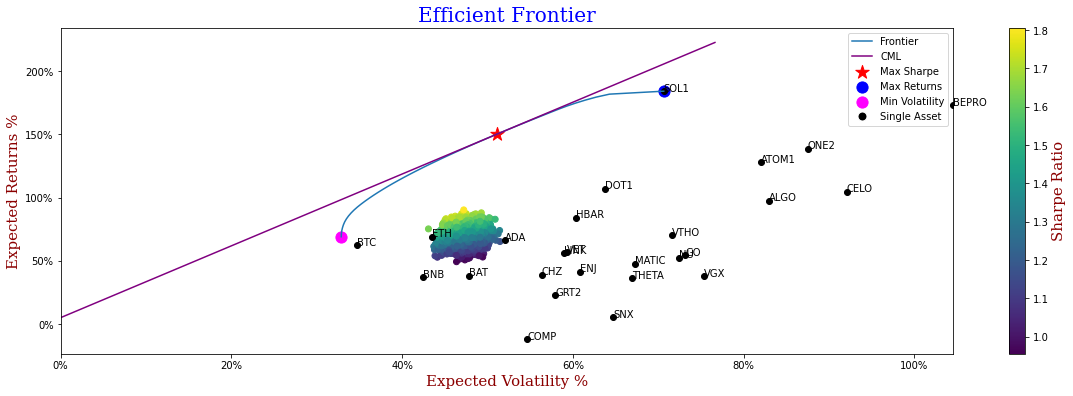

Max Returns: [{'SOL1': 100.0}]
Min Volatility: [{'BNB': 8.2}, {'BTC': 76.3}, {'CELO': 9.6}, {'SOL1': 4.1}, {'VGX': 1.8}]
Max Sharpe: [{'ATOM1': 2.0}, {'BEPRO': 15.1}, {'BTC': 18.2}, {'CELO': 7.6}, {'ONE2': 6.6}, {'SOL1': 50.4}]


In [3]:
plot_results(mean_returns, cov_matrix, delta_days, assets)